### In this notebook, we apply `popsed` to GAMA photometry catalog.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [2]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
name = 'NMF'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol',
                 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'],
    device='cuda', use_speclite=True)

gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

# gama_filters = ['sdss_{0}0'.format(b) for b in 'ugriz'] + ['VIKING_{0}'.format(b) for b in list('YJH')]
# speculator._calc_transmission(gama_filters, filter_dir='./filters/gama/')

noise = 'gama' #'snr' #None # 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [3]:
test_par = torch.Tensor([[.1, 0.1, 0.1, 0.0, 4, -1.3, 1.2, 1.2, 0, 0.02, 8.0],
                         [0.5, 0.5, 0.5, 0.5, 4, -1.3, 1.2, 1.2, 0, 0.3, 10.0]]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(test_par, noise='gama', #SNR=5,
                                           noise_model_dir=noise_model_dir)
mags

tensor([[21.5038, 20.9313, 20.1992, 20.0081, 19.9127],
        [23.4536, 23.4543, 22.5901, 22.0616, 21.3330]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [4]:
### VIKING filters: http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set

#### Load GAMA photometry catalog

In [52]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [53]:
X_data = np.load('./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch.npy')[:, :5]
print('Total number of samples:', len(X_data))

Total number of samples: 110612


In [54]:
z_mass_met = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')

In [55]:
flag = (z_mass_met[:, 0] < 0.35) & ((z_mass_met[:, 0] > 0.15))

In [56]:
X_data = X_data[flag]

In [57]:
z_mass_met = z_mass_met[flag]

In [58]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [59]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [60]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0.15, 0.35])
_prior_NDE[-1] = np.array([7.5, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

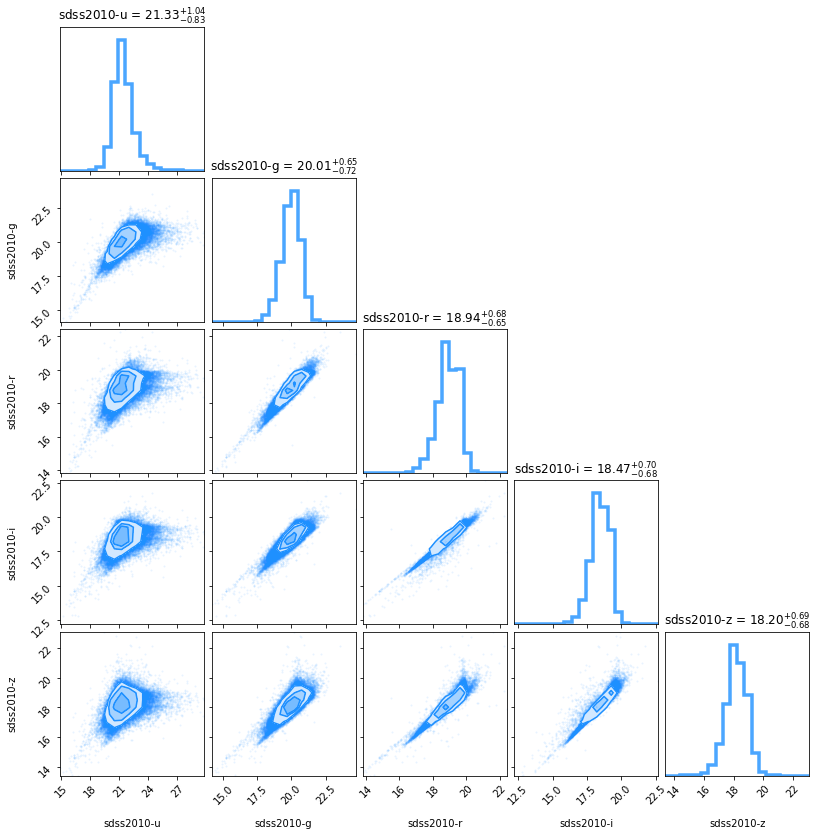

In [61]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data,#.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [62]:
X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)

### now we provide the redshift distribution to it

In [63]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [65]:
noise = None

In [66]:
seed = 4
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 30), 
                   np.abs(np.random.normal(size=len(_bounds)) / 30)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,  # 10
                                              num_bins=50,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [67]:
NDE_theta.build(
    Y_train,#[:, :-1],
    X_train,
    filterset=gama_filters,
    z_score=False,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = None

[ 0.00278063  0.00020838  0.00986578  0.02097025  0.00394868 -0.03703416
  0.04983031 -0.01967798 -0.00788417 -0.00737224 -0.00313551]
Total number of params in the model: 2479030


In [68]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

In [69]:
max_epochs = 3
# blurs = [0.002, 0.002]# * 4
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# blurs = [0.2] * 6
steps = 100
blurs = [0.3, 0.2, 0.1, 0.1, 0.1, 0.1]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.01]


scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=5e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=5,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 1.9999999999999998e-05
    blur: 0.3


Loss = 0.038 (train), 0.036 (vali), 1.081 (bad ratio): 100%|████████| 100/100 [02:22<00:00,  1.43s/epochs]


    Epoch 1
    lr: 0.0004966226619902864
    blur: 0.2


Loss = 0.037 (train), 0.033 (vali), 1.014 (bad ratio): 100%|████████| 100/100 [02:22<00:00,  1.42s/epochs]


    Epoch 2
    lr: 0.00022759126241345056
    blur: 0.1


Loss = 0.061 (train), 0.059 (vali), 1.033 (bad ratio): 100%|████████| 100/100 [02:24<00:00,  1.45s/epochs]


In [15]:
max_epochs = 3
# blurs = [0.002, 0.002]# * 4
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# blurs = [0.2] * 6
steps = 100
blurs = [0.2, 0.1, 0.05, 0.1, 0.1, 0.1]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.01]


scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=5,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 1.200000000000002e-05
    blur: 0.2


Loss = 0.134 (train), 0.134 (vali), 1.599 (bad ratio): 100%|████████████████████████████| 100/100 [02:20<00:00,  1.41s/epochs]


    Epoch 1
    lr: 0.0002979735971941718
    blur: 0.1


Loss = 0.173 (train), 0.190 (vali), 1.700 (bad ratio): 100%|████████████████████████████| 100/100 [02:24<00:00,  1.45s/epochs]


    Epoch 2
    lr: 0.00013655475744807032
    blur: 0.05


Loss = 0.441 (train), 0.451 (vali), 2.296 (bad ratio):  42%|████████████▏                | 42/100 [01:02<01:26,  1.50s/epochs]


ValueError: Maximum allowed size exceeded

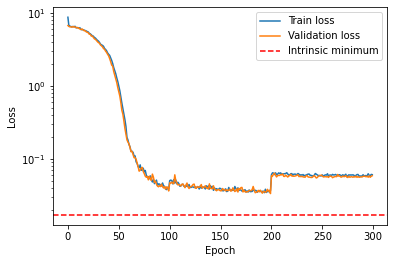

In [70]:
NDE_theta.plot_loss()
plt.yscale('log')

In [71]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 200
Best train loss: 0.03666406124830246
Best vali loss: 0.03336704894900322


In [72]:
from popsed.nde import transform_nmf_params_given_z, inverse_transform_nmf_params_given_z

In [73]:
samples = NDE_theta.sample(4000)

0 4000
>40 0


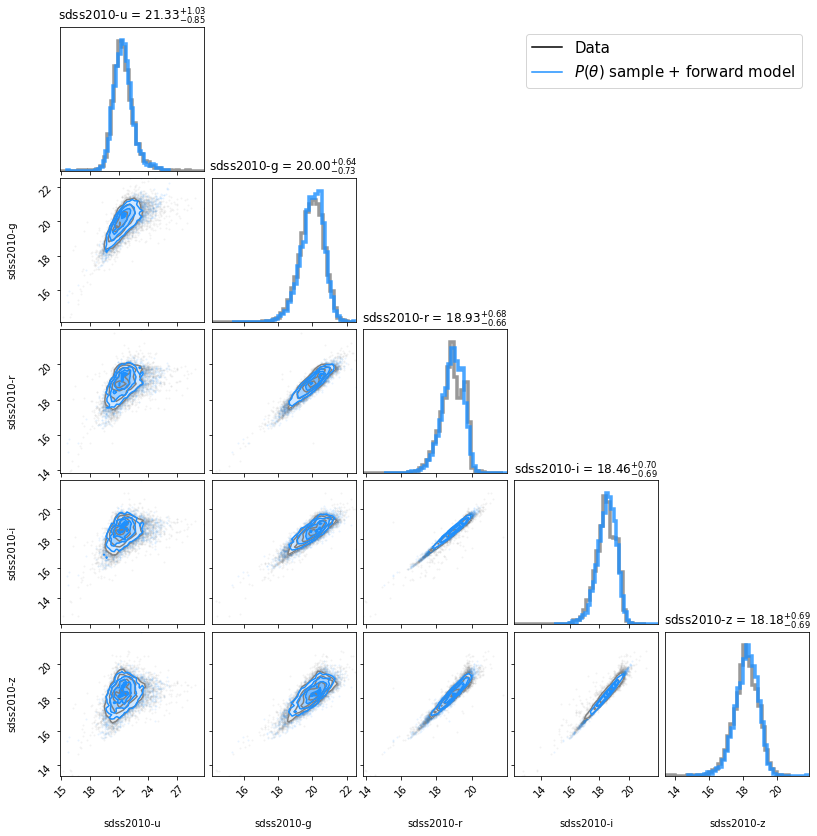

In [74]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [75]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

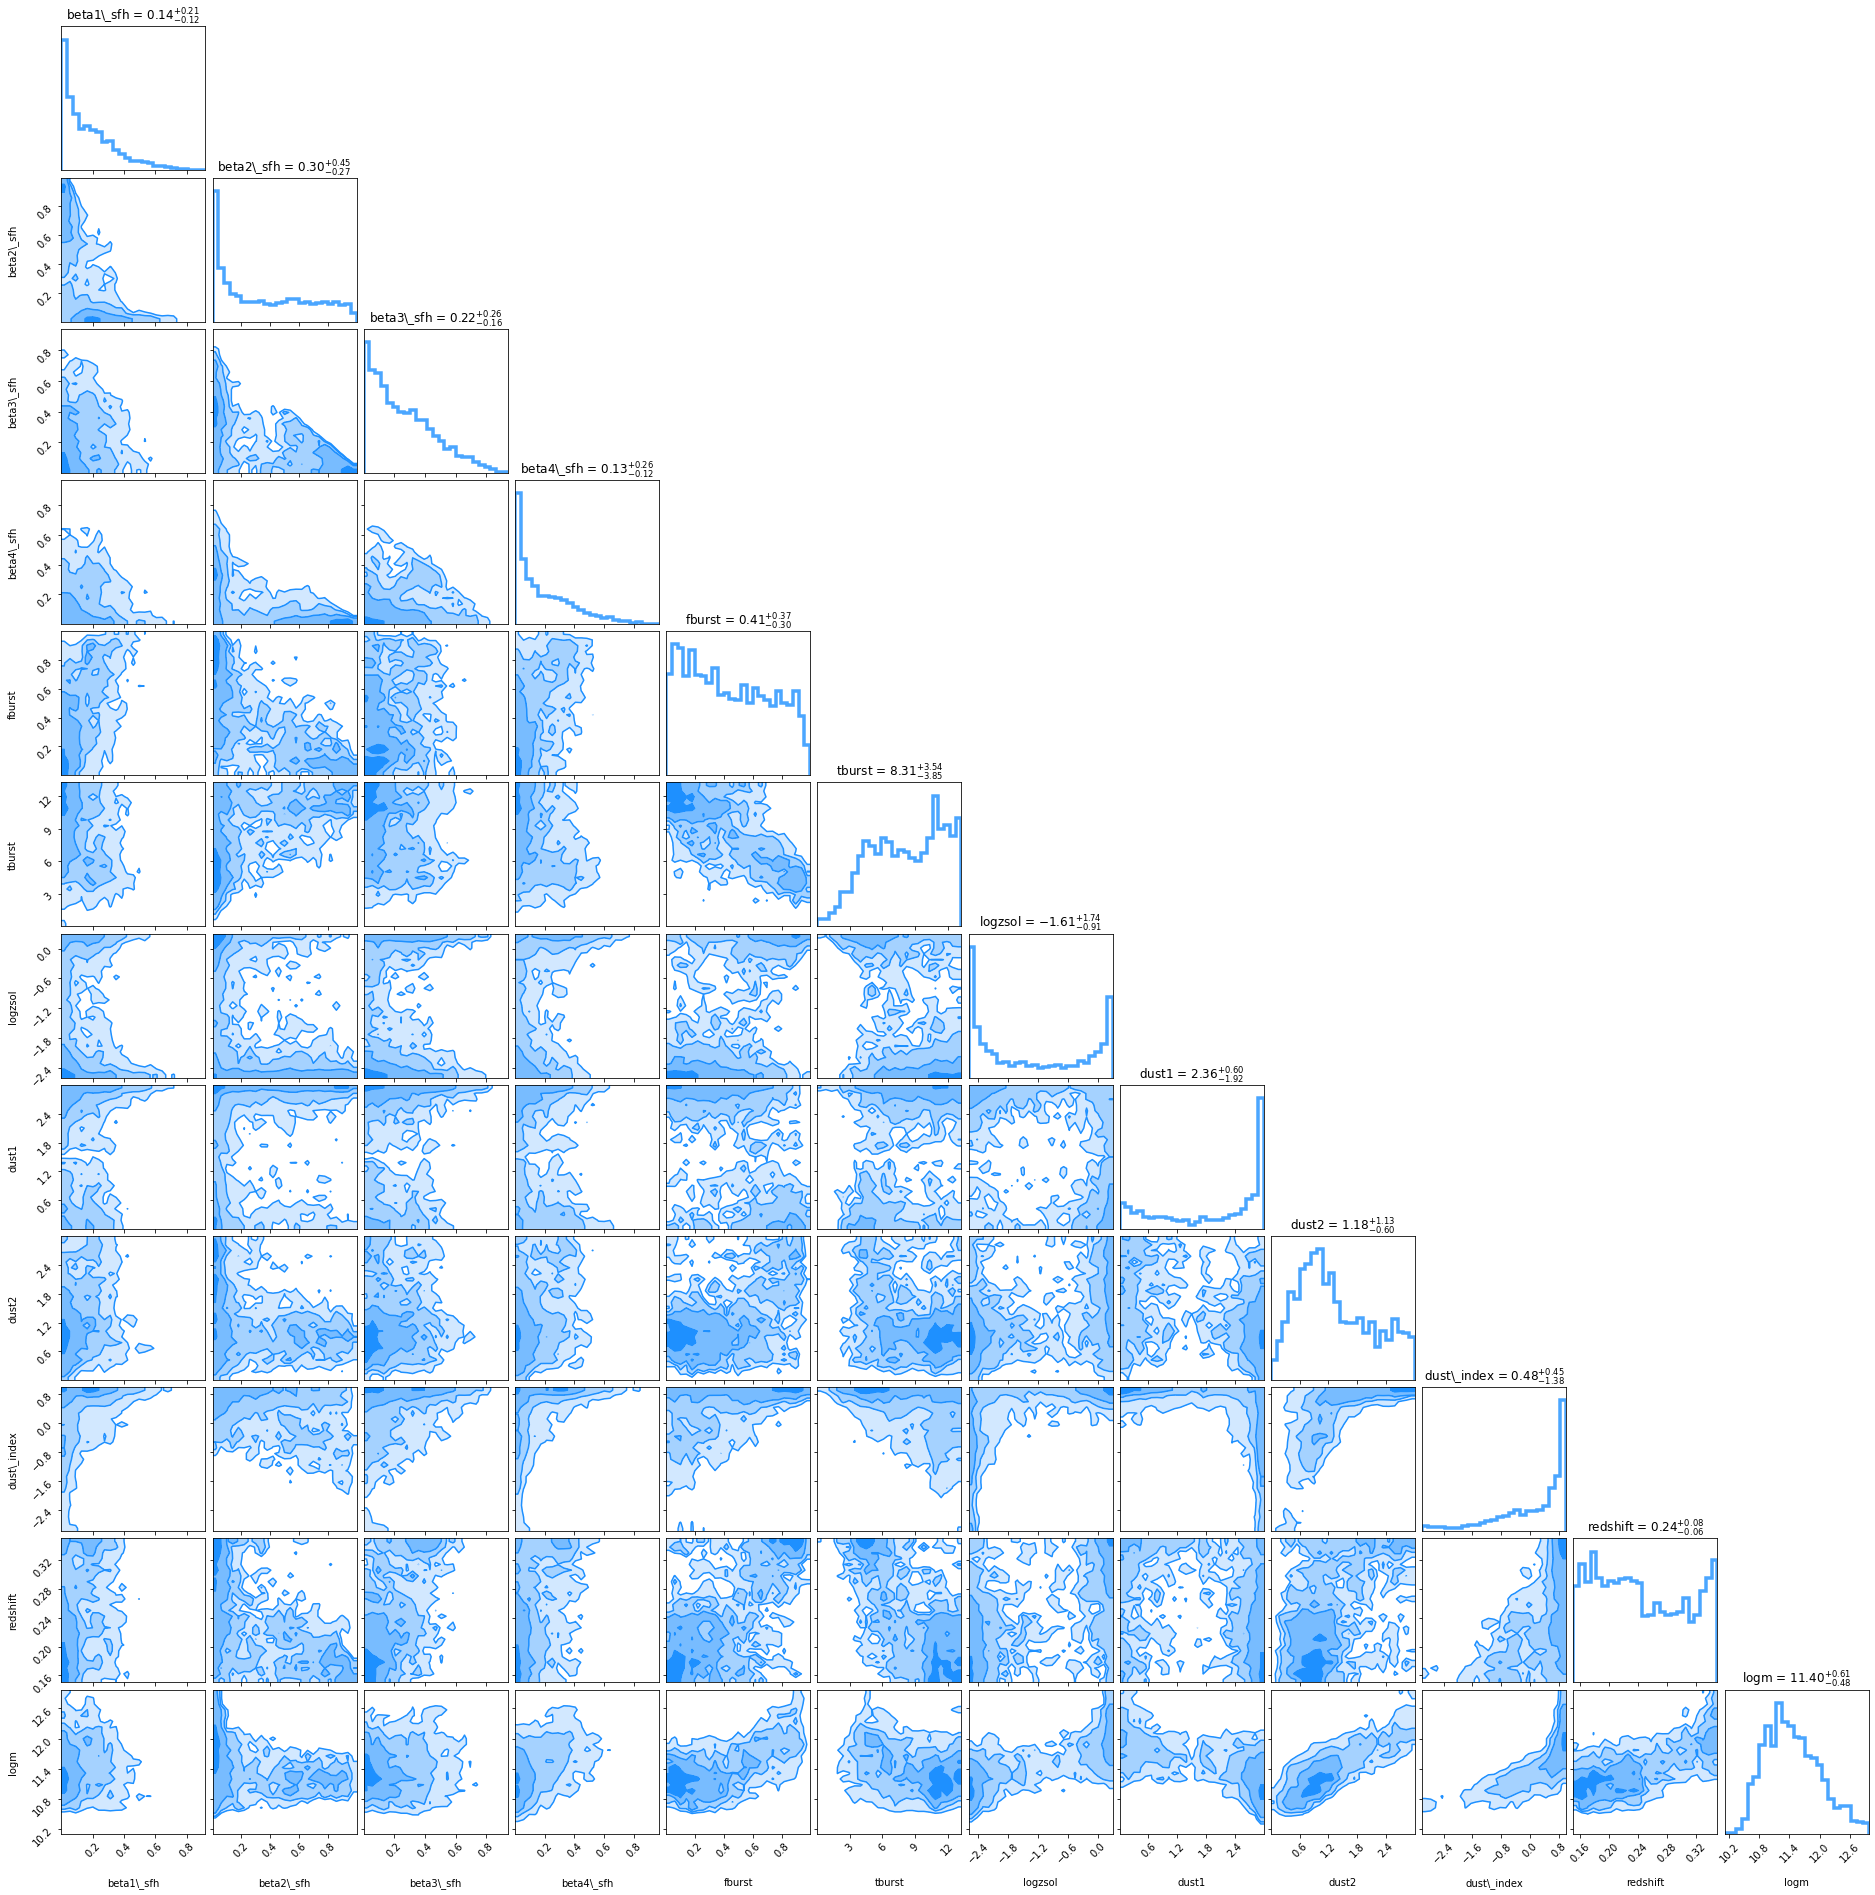

In [76]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

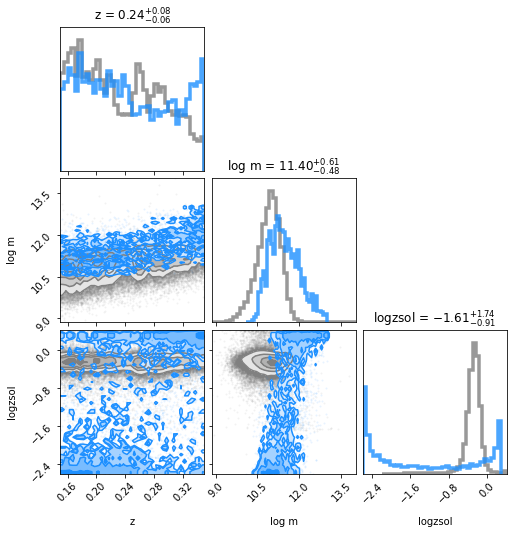

In [77]:
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
#                        range=[[0, 1], [8, 12], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:], _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

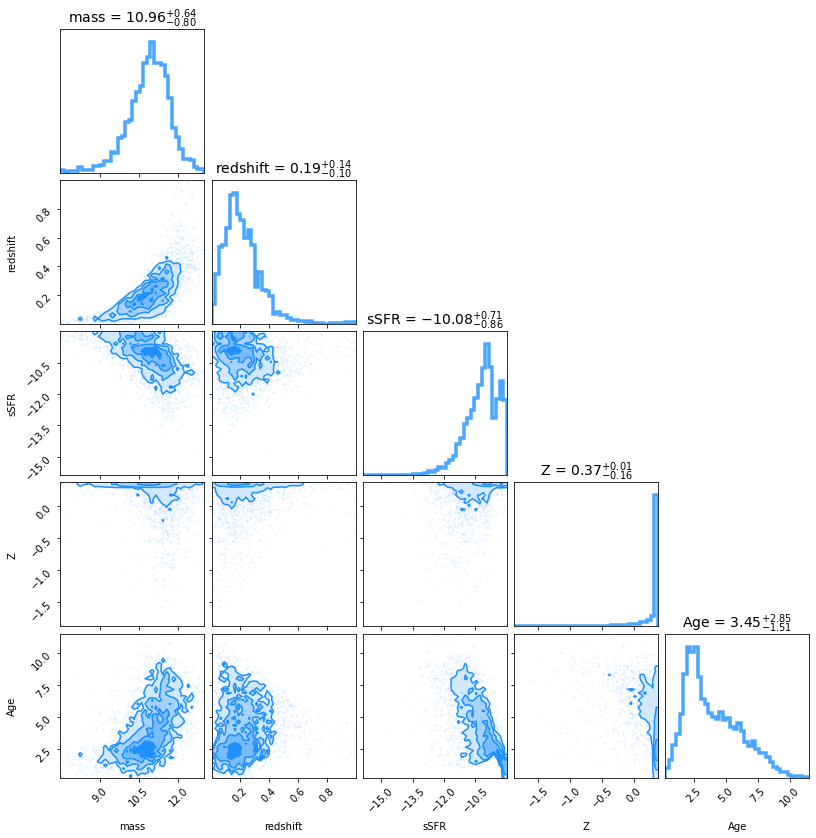

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [59]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

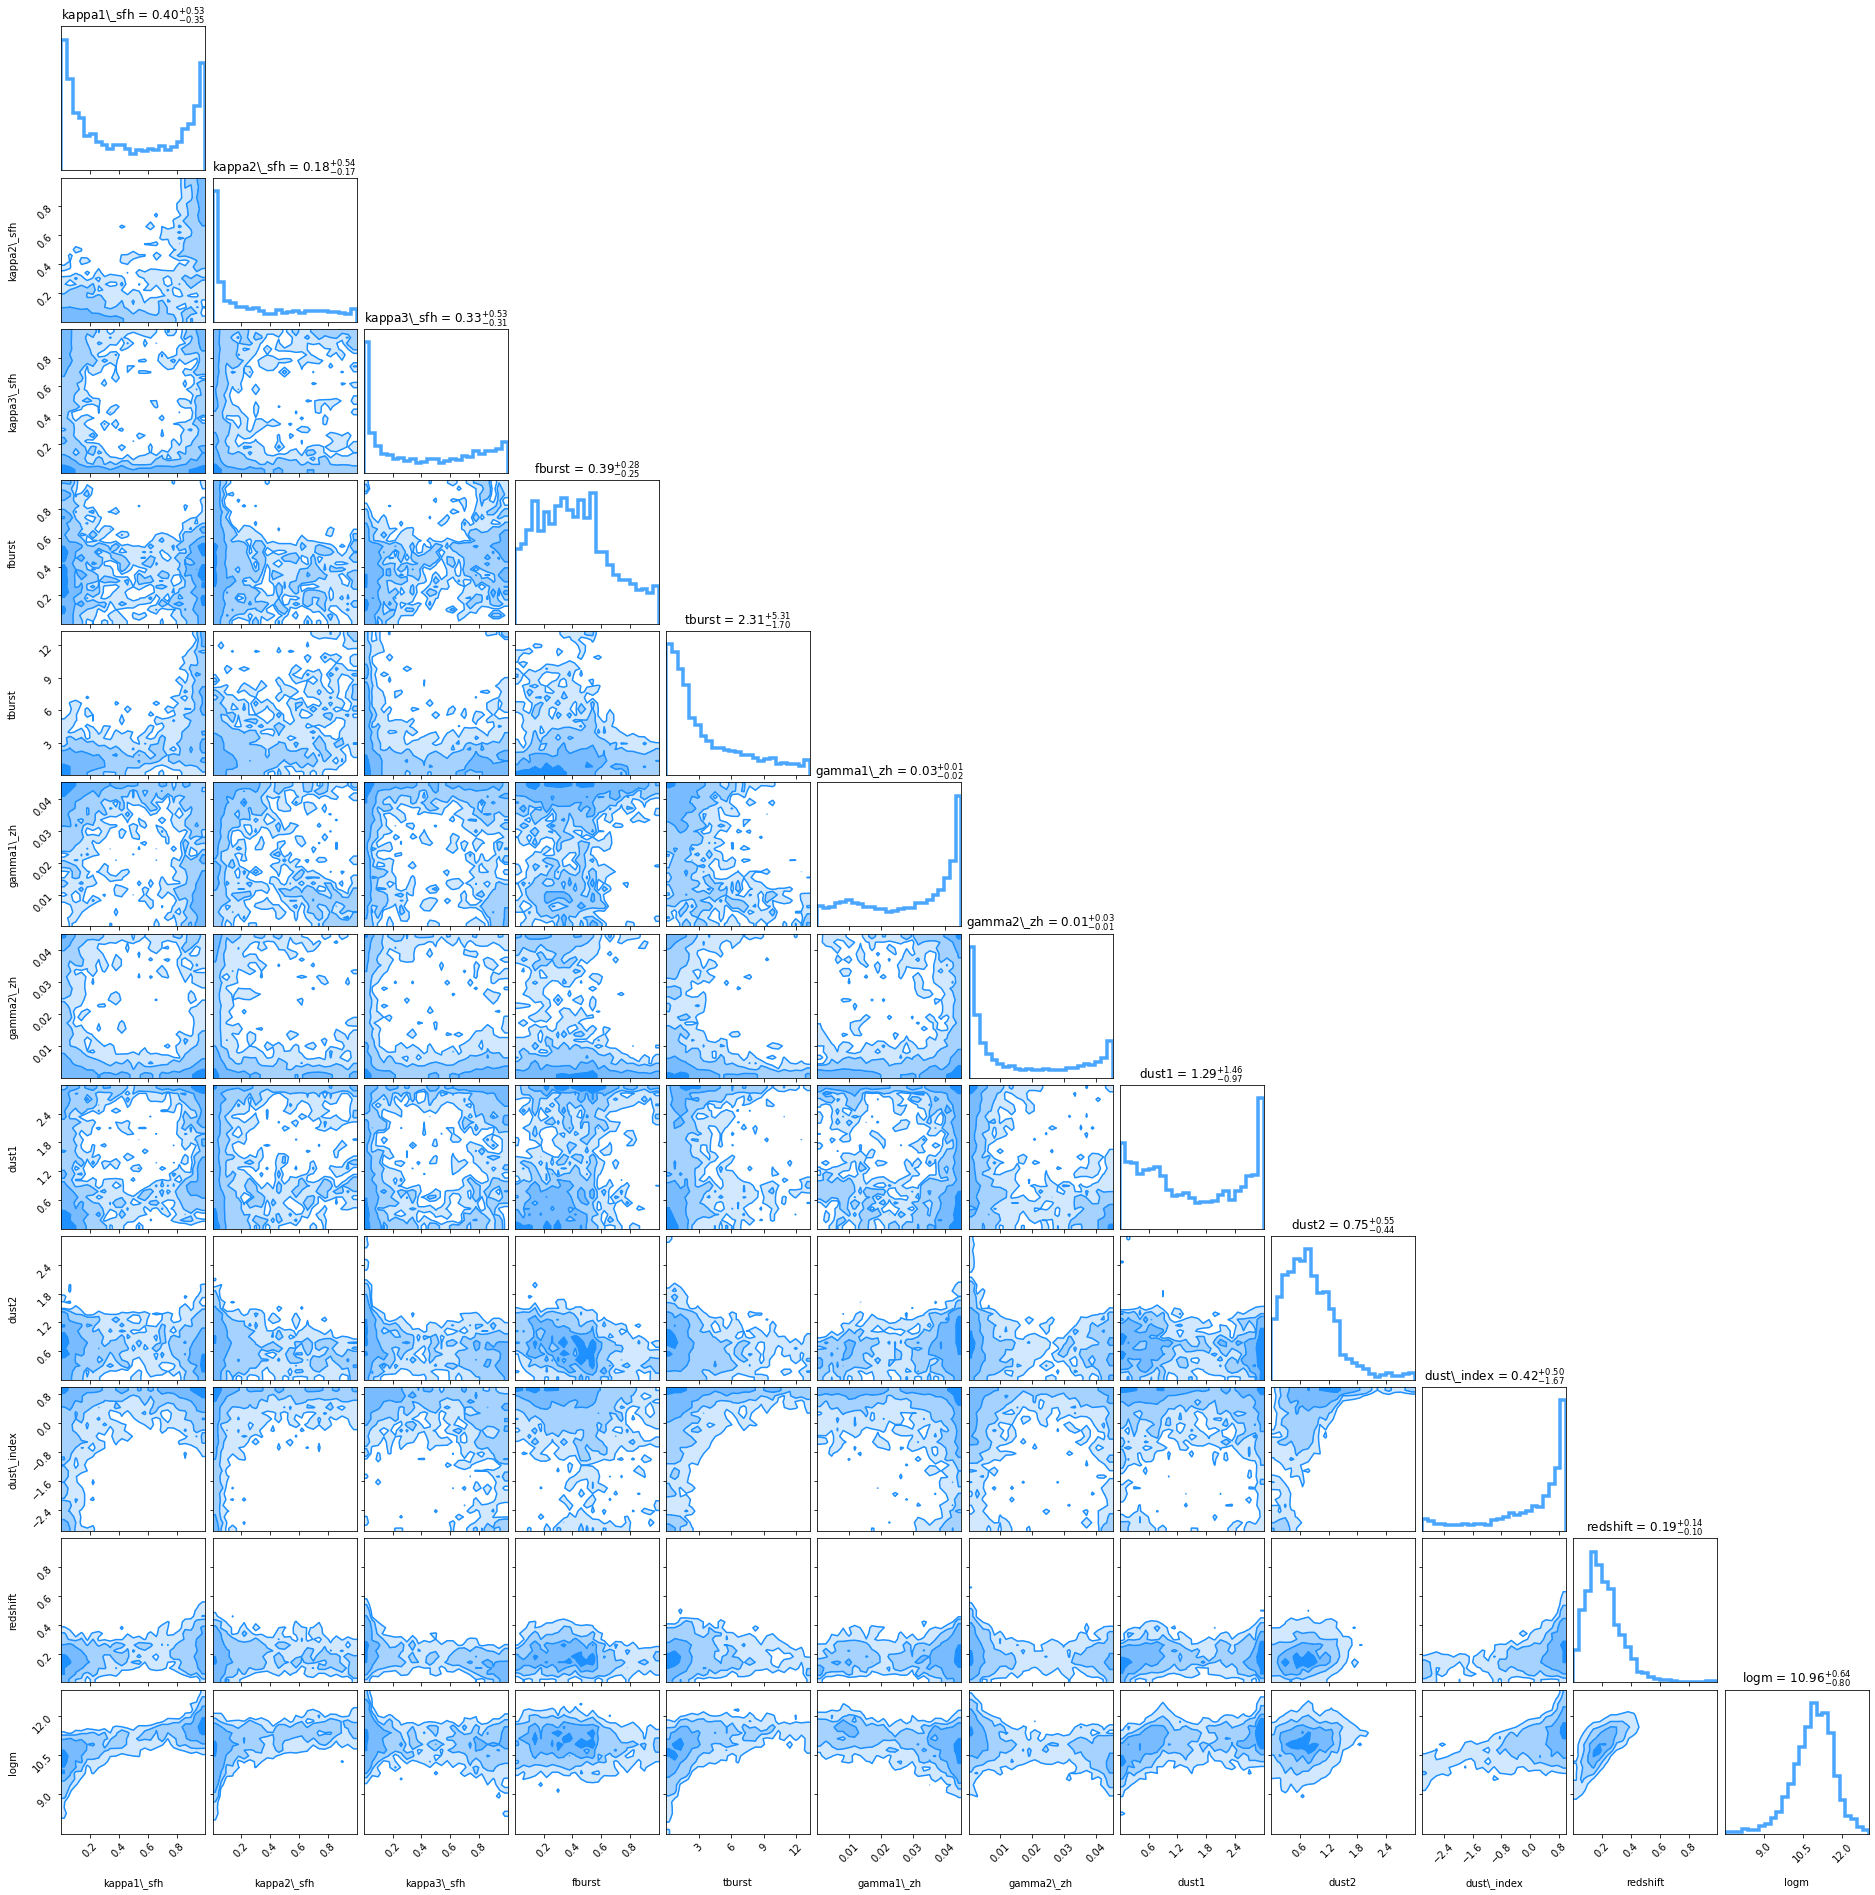

In [60]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))